# Translation using OCR

In this notebook, we will check outan application of OCR, text translation.

<hr style="border:2px solid gray"> </hr>
  

## Workflow

- Import vocabulary of language and the text detection and recognition model packages
- Read the image, idenitfy, the size of the input image and scale it down to optimum size
- Apply text detector on the image to obtain the confusion matrix and the bounding box vertices of the text
- Apply text recognizer on each box by box 
- Plot detected output text box by box on the output template file
- Print the detected text
- Detect language of the detected text using the google tranlate language engine
- Tranlate the detected text to the selected language using the "googletrans" google tranlate language engine
- Convert the text to speech using the pyttsx3 text to speech engine

## Import the required libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pyttsx3
import googletrans
from googletrans import Translator


plt.rcParams['image.cmap'] = 'gray'

## Display Image to be used

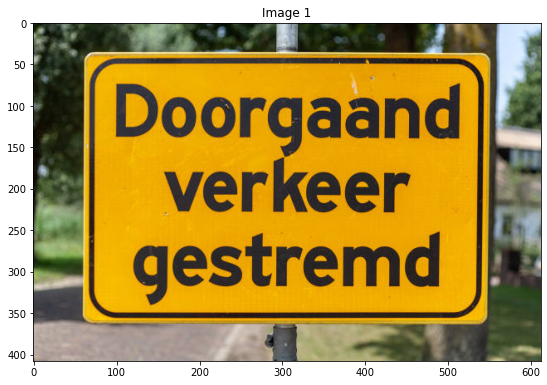

In [2]:
# Load Image
img1 = cv2.imread('/Users/aneerbanchakraborty/Documents/git/C0/c0-module-text-detection-ocr/visuals/dutch_signboard.jpg')

# Display the image
plt.figure(figsize=(20,20))
plt.subplot(121); plt.imshow(img1[:,:,::-1]); plt.title('Image 1');

## Initialise the google tranlator engine

### <font style="color:rgb(8,133,37)">Google Translator Python API documentation</font>

[**`googletrans()`**](https://py-googletrans.readthedocs.io/en/latest/)

In [3]:
translator = Translator()

## Initialise the text to speech engine

### <font style="color:rgb(8,133,37)">Python Text-to-Speech API documentation</font>

[**`pyttsx3()`**](https://pyttsx3.readthedocs.io/en/latest/index.html)

In [4]:
speechEngine =  pyttsx3.init()
speechEngine.setProperty("rate", 120)

## Import the Language Vocabulary to be used for the text recognition

### <font style="color:rgb(8,133,37)">The detected text in the image is converted into text data using this vocabulary as reference.</font>

In [5]:
# Define list to store the vocabulary in
vocabulary =[]

# Open file to import the vocabulary
with open("/Users/aneerbanchakraborty/Documents/git/C0/c0-module-text-detection-ocr/resources/alphabet_94.txt") as f:

    # Read the file line by line
    for l in f:
    
        # Append each line into the vocabulary list.
        vocabulary.append(l.strip())
    
    #Close the file
    f.close()

# Print the data
print("Vocabulary:", vocabulary, len(vocabulary))

Vocabulary: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~'] 94


In [6]:
# DB model for text-detection based on resnet50
text_detector = cv2.dnn_TextDetectionModel_DB("/Users/aneerbanchakraborty/Documents/git/C0/c0-module-text-detection-ocr/resources/DB_TD500_resnet50.onnx")
binThresh = 0.3
polyThresh = 0.5
maxCandidates = 200
unclipRatio = 2.0

text_detector.setBinaryThreshold(binThresh).setPolygonThreshold(polyThresh).setMaxCandidates(maxCandidates).setUnclipRatio(unclipRatio)
text_detector.setInputParams(1.0/255, (736, 736), (122.67891434, 116.66876762, 104.00698793) , True)

In [7]:
# CRNN model for text-recognition
text_recogniser = cv2.dnn_TextRecognitionModel("/Users/aneerbanchakraborty/Documents/git/C0/c0-module-text-detection-ocr/resources/crnn_cs.onnx")
text_recogniser.setDecodeType("CTC-greedy")
text_recogniser.setVocabulary(vocabulary)
text_recogniser.setInputParams(1/127.5, (100,32), (127.5, 127.5, 127.5))

## Funtion for transforming boxes

[**`Geometric Image Transforms()`**]
(https://docs.opencv.org/4.5.2/da/d54/group__imgproc__transform.html)

In [8]:
# This Function does transformation over the bounding boxes detected by the text detection model
def fourPointsTransform(frame, vertices):
    
    # Print vertices of each bounding box 
    vertices = np.asarray(vertices).astype(np.float32)
    print("Vertices of Bounding box : ", vertices )
    outputSize = (100, 32)
    targetVertices = np.array([
        [0, outputSize[1] - 1],
        [0, 0],
        [outputSize[0] - 1, 0],
        [outputSize[0] - 1, outputSize[1] - 1]], dtype="float32")
    
    # Apply perspective transform
    rotationMatrix = cv2.getPerspectiveTransform(vertices, targetVertices)
    result = cv2.warpPerspective(frame, rotationMatrix, outputSize)
    return result

## Set Scale Factor for resize 

In [9]:
# Defining function that returns the scale factor to resize the output image according to 
# the size/shape matrix of the input image
def setScaleFactor(frame):
    
    #Get image height and width
    frame_h, frame_w, ch = frame.shape
    
    # Define scaling factor according to preset values of the input image size so as 
    # the output image is scaled down to a generic size,"k" is the scaling factor value
    if (frame_h > 2000) and (frame_w > 2000):
        k = 0.2
    elif (2000 > frame_h > 1000) and 2000 > frame_w > 1000:
        k = 0.4
    elif (frame_h < 1000) or frame_w < 1000:
        k = 0.6
    elif (frame_h < 500) and frame_w < 500:
        k = 1
    else:
        k = 0.5
    return k

# Text detection and recognition

Vertices of Bounding box :  [[ 70. 208.]
 [ 67. 150.]
 [296. 138.]
 [299. 197.]]
Text Recognized :  gestremd
Check boxes 70  and  208 

Vertices of Bounding box :  [[ 93. 142.]
 [ 93.  95.]
 [272.  97.]
 [272. 143.]]
Text Recognized :  verkeer
Check boxes 93  and  142 

Vertices of Bounding box :  [[ 53.  96.]
 [ 53.  36.]
 [311.  41.]
 [311. 101.]]
Text Recognized :  Doorgaand
Check boxes 53  and  96 



Text(0.5, 1.0, 'Output')

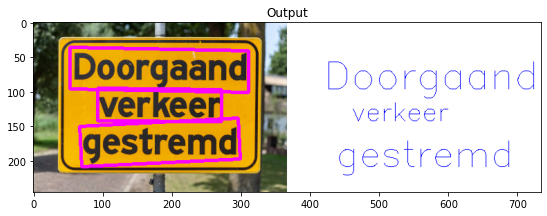

In [10]:
# Get the scaling factor
scaling_factor = setScaleFactor(img1)
# Resize the image depending on the original image shape and the scaling factor
image = cv2.resize(img1, None, fx= scaling_factor, fy= scaling_factor, interpolation= cv2.INTER_LINEAR)

# Create a blank matrix to be used to display the output image
blank = np.full(image.shape[:2],255, dtype =np.uint8)
# Convert the blank matrix into a image with white background.
temp=[blank,blank,blank]
image_white=cv2.merge(temp,3)

# Use the DB text detector initialised previously to detect the presence of text in the image
boxes, confs = text_detector.detect(image)

text_data=[]

#Iterate throught the bounding boxes detected by the text detector model
for box in boxes:
    
    # Apply transformation on the bounding box detected by the text detection algorithm
    cropped_roi  = fourPointsTransform(image,box)
    
    # Recognise the text using the crnn model
    recResult = text_recogniser.recognize(cropped_roi)
    
    # Get scaled values
    box_height = int((abs((box[0,1]-box[1,1]))))
    # 10% of height box
    scale = int(abs((box[0,1]-box[1,1])/10)) 
    area = abs((box[0,1]-box[1,1])) * abs((box[0,0]-box[1,0]))
    tk = int(area/10)
    
    # Get scale of the font
    fontScale = cv2.getFontScaleFromHeight( cv2.FONT_HERSHEY_SIMPLEX, 
        box_height-20, 1 )
    
    # Write the recognised text on the output image
    cv2.putText(image_white, recResult, (int( box[0,0]),int( box[0,1])),
        cv2.FONT_HERSHEY_SIMPLEX, fontScale, (255, 0,0), 1, 5)
    
    print("Text Recognized : ",recResult)
    print('Check boxes',int( box[0,0]),' and ',int( box[0,1]),"\n")
    
    # Append recognised text to the data storage variable
    text_data.append(recResult)

# Joining the text data together to form a output sentence
text_data=' '.join(text_data)

# Draw the bounding boxes of text detected.
cv2.polylines(image, boxes, True, (255, 0, 255), 4)

# Concatenate the input image with the output image
canvas = cv2.hconcat([image,image_white])


# Display the output Image
plt.figure(figsize=(20,20))
plt.subplot(121); plt.imshow(canvas[:,:,::-1]); plt.title('Output')

## Detect the language and translate it to the selected language

In [11]:
# Detect the language of the text acquired
print("Detected Language : ",googletrans.LANGUAGES[translator.detect(text_data).lang])
# Select the language to be translated into out of the list
print(googletrans.LANGUAGES)
dest = input("Translate into : ")

# Print the translated text
print("--->" , translator.translate(text_data,dest).text)

Detected Language :  dutch
{'af': 'afrikaans', 'sq': 'albanian', 'am': 'amharic', 'ar': 'arabic', 'hy': 'armenian', 'az': 'azerbaijani', 'eu': 'basque', 'be': 'belarusian', 'bn': 'bengali', 'bs': 'bosnian', 'bg': 'bulgarian', 'ca': 'catalan', 'ceb': 'cebuano', 'ny': 'chichewa', 'zh-cn': 'chinese (simplified)', 'zh-tw': 'chinese (traditional)', 'co': 'corsican', 'hr': 'croatian', 'cs': 'czech', 'da': 'danish', 'nl': 'dutch', 'en': 'english', 'eo': 'esperanto', 'et': 'estonian', 'tl': 'filipino', 'fi': 'finnish', 'fr': 'french', 'fy': 'frisian', 'gl': 'galician', 'ka': 'georgian', 'de': 'german', 'el': 'greek', 'gu': 'gujarati', 'ht': 'haitian creole', 'ha': 'hausa', 'haw': 'hawaiian', 'iw': 'hebrew', 'he': 'hebrew', 'hi': 'hindi', 'hmn': 'hmong', 'hu': 'hungarian', 'is': 'icelandic', 'ig': 'igbo', 'id': 'indonesian', 'ga': 'irish', 'it': 'italian', 'ja': 'japanese', 'jw': 'javanese', 'kn': 'kannada', 'kk': 'kazakh', 'km': 'khmer', 'ko': 'korean', 'ku': 'kurdish (kurmanji)', 'ky': 'kyrgy

## Text to speech

In [12]:
# Speak out the translated text using the text to speech engine
speechEngine.say(translator.translate(text_data,dest).text)
speechEngine.runAndWait()




## Conslusion

Detection of text data in an image is done using DB text detection model
and the recognition and conversion of that into text data is done using the CRNN model.The text is then converted to the language chosen by the by the user using google translate engine.Then translated text is then conveted to speech using the pyttsx3 text-to-speech engine.

### Remarks

- The text recognition model works with only latin alphabets as the vocabulary is set for latin alphabets

<hr style="border:2px solid gray"> </hr>









